<a href="https://colab.research.google.com/github/fazalpge/product_forecasting/blob/main/Multivariate_multiple_timeseries_forecasting_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
from prophet import Prophet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [34]:
class ProphetModel(BaseEstimator, TransformerMixin):
    def __init__(self, periods=30, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=None):
        self.periods = periods
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays
        self.models = {}

    def fit(self, X, y=None):
        unique_combinations = X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            location, item_name = row['Location'], row['ItemName']
            sub_df = self._prepare_sub_df(X, location, item_name)
            if sub_df.dropna().shape[0] >= 2:
                model = self._initialize_model()
                model.fit(sub_df)
                self.models[(location, item_name)] = model
            else:
                print(f"Skipping combination Location: {location}, ItemName: {item_name} due to insufficient data")
        return self

    def _prepare_sub_df(self, X, location, item_name):
        sub_df = X[(X['Location'] == location) & (X['ItemName'] == item_name)].copy()
        sub_df = sub_df.rename(columns={'TransactionDate': 'ds', 'SaleAmount': 'y', 'SaleBonusQty': 'bonus_qty'})
        sub_df['ds'] = pd.to_datetime(sub_df['ds'], format='%Y-%m-%d')
        sub_df['bonus_qty'] = sub_df['bonus_qty'].fillna(0)
        return sub_df

    def _initialize_model(self):
        model = Prophet(
            yearly_seasonality=self.yearly_seasonality,
            weekly_seasonality=self.weekly_seasonality,
            daily_seasonality=self.daily_seasonality,
            holidays=self.holidays
        )
        model.add_regressor('bonus_qty', standardize=False)
        return model

    def transform(self, X, interval='daily', location=None, item_name=None):
        forecast_df = pd.DataFrame()
        filtered_X = self._filter_data(X, location, item_name)
        unique_combinations = filtered_X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            loc, itm = row['Location'], row['ItemName']
            if (loc, itm) in self.models:
                model = self.models[(loc, itm)]
                forecast = self._make_forecast(model, filtered_X, loc, itm, interval)
                forecast_df = pd.concat([forecast_df, forecast], ignore_index=True)
        return forecast_df

    def _filter_data(self, X, location, item_name):
        if location and item_name:
            return X[(X['Location'] == location) & (X['ItemName'] == item_name)]
        elif location:
            return X[X['Location'] == location]
        elif item_name:
            return X[X['ItemName'] == item_name]
        else:
            return X

    def _make_forecast(self, model, X, location, item_name, interval):
        future = model.make_future_dataframe(periods=self.periods, freq=self.get_frequency(interval))
        future = pd.merge(future, X[['ds', 'bonus_qty']], on='ds', how='left')
        future['bonus_qty'] = future['bonus_qty'].fillna(0)
        forecast = model.predict(future)
        forecast['Location'] = location
        forecast['ItemName'] = item_name
        return forecast

    def get_frequency(self, interval):
        interval_mapping = {
            'daily': 'D',
            'weekly': 'W',
            'monthly': 'M',
            'half-yearly': '6M',
            'yearly': 'Y'
        }
        return interval_mapping.get(interval, 'D')

    def plot_forecast(self, X, interval='daily', location=None, item_name=None):
        forecast_df = self.transform(X, interval=interval, location=location, item_name=item_name)
        self._plot(forecast_df, location, item_name)

    def _plot(self, forecast_df, location, item_name):
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='gray', alpha=0.2)
        if location and item_name:
            title = f'Forecast for {location} - {item_name}'
        elif location:
            title = f'Forecast for {location}'
        elif item_name:
            title = f'Forecast for {item_name}'
        else:
            title = 'Forecast'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('SaleAmount')
        plt.legend()
        plt.show()

In [35]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/fazalpge/product_forecasting/main/Inventory%20Data_fazal.csv')


In [5]:
df.isnull().sum()

TransactionDate            0
Location                   0
ItemName                   0
Cost                       0
SaleQty                    0
SaleBonusQty               0
SaleTotalQty               0
MRP                        0
SaleAmount                 0
PerInvoiceAverageAmount    0
dtype: int64

In [36]:
# Ensure the date column is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

<ipython-input-36-af55811504b3>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [37]:
# Rename 'TransactionDate' to 'ds' and 'SaleBonusQty' to 'bonus_qty' for consistency
df = df.rename(columns={'TransactionDate': 'ds', 'SaleBonusQty': 'bonus_qty'})

In [38]:
# Define holidays (example, you should replace this with actual holiday dates)
holidays = pd.DataFrame({
    'holiday': 'example_holiday',
    'ds': pd.to_datetime(['2023-01-01', '2023-12-25'], format='%Y-%m-%d'),
    'lower_window': 0,
    'upper_window': 1,
})

In [39]:
# Create a pipeline
pipeline= Pipeline([
    ('prophet', ProphetModel(
        periods=30,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays
    ))
])

In [40]:
pipeline

Pipeline(steps=[('prophet',
                 ProphetModel(holidays=           holiday         ds  lower_window  upper_window
0  example_holiday 2023-01-01             0             1
1  example_holiday 2023-12-25             0             1))])

In [41]:
# Fit the pipeline
pipeline.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/wfh8w_yc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/kxb6ucsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63031', 'data', 'file=/tmp/tmpl3ihxiin/wfh8w_yc.json', 'init=/tmp/tmpl3ihxiin/kxb6ucsj.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_model_3vrmvdd/prophet_model-20240611113645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/9n61aq36.json
DEBUG:cmdstanpy:input tempfile:

Skipping combination Location: Corporate, ItemName: Vivabond (5Ltr.) due to insufficient data
Skipping combination Location: Corporate, ItemName: Fresmin F 10kg due to insufficient data
Skipping combination Location: Corporate, ItemName: Stable Bleaching Powder 25kg due to insufficient data
Skipping combination Location: Corporate, ItemName: K1 Bio Filter Media due to insufficient data


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91305', 'data', 'file=/tmp/tmpl3ihxiin/nitiikn_.json', 'init=/tmp/tmpl3ihxiin/sj4ezk7x.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_modelkzehfkou/prophet_model-20240611113646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/rz52lbvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/jma_khm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64080', 'data', 'file=/tmp/tmpl3ihxiin/rz

Skipping combination Location: Karnaphuli, ItemName: Salivet 500ml due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Salivet 1ltr due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Viusid Vet 500ml due to insufficient data


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/faed9wb6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/gvkgj8c6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=784', 'data', 'file=/tmp/tmpl3ihxiin/faed9wb6.json', 'init=/tmp/tmpl3ihxiin/gvkgj8c6.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_model6d0lizlg/prophet_model-20240611113649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/bj8yh4bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/fir2a39f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runnin

Skipping combination Location: Kopotakkho, ItemName: Gentech - P.S (20 LTr.) due to insufficient data


INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/4uaeqwbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/qe3z9z2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17249', 'data', 'file=/tmp/tmpl3ihxiin/4uaeqwbr.json', 'init=/tmp/tmpl3ihxiin/qe3z9z2s.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_modell59y5mct/prophet_model-20240611113649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/9rxp20tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/81qwck3q.json
D

Skipping combination Location: Muhuri, ItemName: Fresmin F 10kg due to insufficient data


11:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/o_taai9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/4ra7nw6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14207', 'data', 'file=/tmp/tmpl3ihxiin/o_taai9q.json', 'init=/tmp/tmpl3ihxiin/4ra7nw6n.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_modelbqpareis/prophet_model-20240611113652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/jxzvyi0v.json
DEBUG:c

Skipping combination Location: Padma, ItemName: Vivamin (10kg) due to insufficient data
Skipping combination Location: Padma, ItemName: Fresmin F 10kg due to insufficient data
Skipping combination Location: R&D Center, ItemName: Viusid Aqua 150ml due to insufficient data


11:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/fdjf3avi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/4n6ke0j2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31427', 'data', 'file=/tmp/tmpl3ihxiin/fdjf3avi.json', 'init=/tmp/tmpl3ihxiin/4n6ke0j2.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_modelmvcf2t_c/prophet_model-20240611113652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/czeu117z.json
DEBUG:

Skipping combination Location: Rupsha, ItemName: Fresmin F 10kg due to insufficient data


11:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/n0_bcv54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3ihxiin/j_r3_q7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4751', 'data', 'file=/tmp/tmpl3ihxiin/n0_bcv54.json', 'init=/tmp/tmpl3ihxiin/j_r3_q7t.json', 'output', 'file=/tmp/tmpl3ihxiin/prophet_modelc3t5_0b8/prophet_model-20240611113656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Tista, ItemName: Fresmin F 10kg due to insufficient data


11:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pipeline(steps=[('prophet',
                 ProphetModel(holidays=           holiday         ds  lower_window  upper_window
0  example_holiday 2023-01-01             0             1
1  example_holiday 2023-12-25             0             1))])

In [42]:
# Make predictions by calling transform on the ProphetModel directly
forecast_df= pipeline.named_steps['prophet'].transform(df, interval='daily')
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-5077.858029,41201.134787,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8687.906820,58589.807044,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10473.501916,38957.195183,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41879.297227,88182.392097,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,35716.930509,85389.269528,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,2023-11-17,17453.617305,7083.847013,58711.827479,17453.616739,17453.617856,16146.807720,16146.807720,16146.807720,0.000,...,-2778.751462,18925.559181,18925.559181,18925.559181,0.0,0.0,0.0,33600.425024,Turag,Clean 100ml
9876,2023-11-18,17441.357712,2130.698468,52723.752750,17441.357121,17441.358296,10207.432002,10207.432002,10207.432002,0.000,...,-3434.972866,13642.404868,13642.404868,13642.404868,0.0,0.0,0.0,27648.789714,Turag,Clean 100ml
9877,2023-11-19,17429.098120,-891.791394,50958.275188,17429.097483,17429.098730,6423.816679,6423.816679,6423.816679,0.000,...,-2038.036593,8461.853272,8461.853272,8461.853272,0.0,0.0,0.0,23852.914799,Turag,Clean 100ml
9878,2023-11-20,17416.838527,5027.148391,58109.037303,17416.837882,17416.839180,15070.786713,15070.786713,15070.786713,0.000,...,11615.709702,3455.077012,3455.077012,3455.077012,0.0,0.0,0.0,32487.625240,Turag,Clean 100ml


In [13]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Location',	'ItemName']].tail()

,ds,yhat,yhat_lower,yhat_upper,Location,ItemName
9875,2023-11-17,33600.425024,8966.304111,60092.220285,Turag,Clean 100ml
9876,2023-11-18,27648.789714,1202.513744,55369.222137,Turag,Clean 100ml
9877,2023-11-19,23852.914799,-3226.901109,49032.764384,Turag,Clean 100ml
9878,2023-11-20,32487.625240,5534.369817,56977.665385,Turag,Clean 100ml
9879,2023-11-21,20948.988968,-5070.261198,47114.458680,Turag,Clean 100ml


In [14]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6621.295918,41836.969357,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9492.762174,59383.475081,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11531.037385,37136.773428,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41749.521545,90436.939689,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36783.031420,83765.461496,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,2023-11-17,17453.617305,8966.304111,60092.220285,17453.616766,17453.617752,16146.807720,16146.807720,16146.807720,0.000,...,-2778.751462,18925.559181,18925.559181,18925.559181,0.0,0.0,0.0,33600.425024,Turag,Clean 100ml
9876,2023-11-18,17441.357712,1202.513744,55369.222137,17441.357151,17441.358188,10207.432002,10207.432002,10207.432002,0.000,...,-3434.972866,13642.404868,13642.404868,13642.404868,0.0,0.0,0.0,27648.789714,Turag,Clean 100ml
9877,2023-11-19,17429.098120,-3226.901109,49032.764384,17429.097523,17429.098628,6423.816679,6423.816679,6423.816679,0.000,...,-2038.036593,8461.853272,8461.853272,8461.853272,0.0,0.0,0.0,23852.914799,Turag,Clean 100ml
9878,2023-11-20,17416.838527,5534.369817,56977.665385,17416.837884,17416.839058,15070.786713,15070.786713,15070.786713,0.000,...,11615.709702,3455.077012,3455.077012,3455.077012,0.0,0.0,0.0,32487.625240,Turag,Clean 100ml


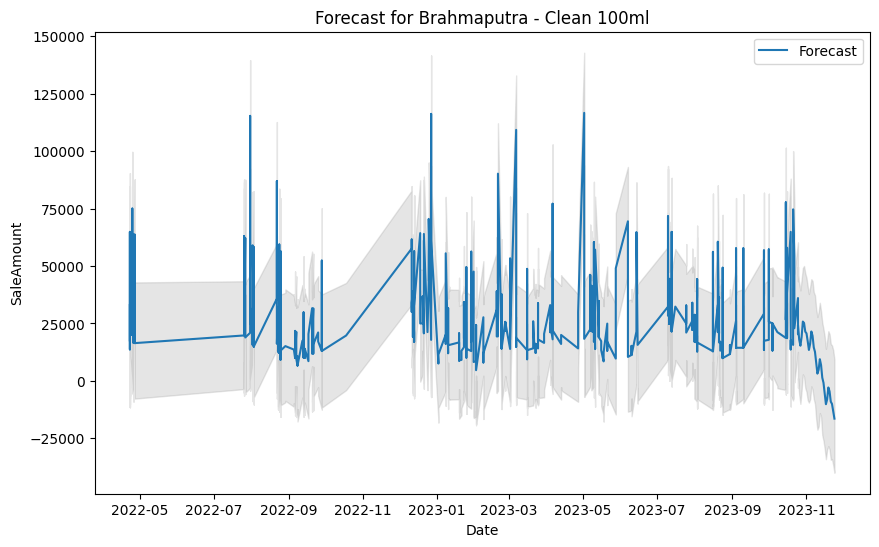

In [15]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [44]:
# Example of generating and displaying weekly forecast
weekly_forecast_df=pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml',interval='weekly')
weekly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7668.983251,42056.163897,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,-5871.973125,43149.748605,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-7422.428362,43108.871562,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,-5788.484589,41794.479002,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,-7417.339846,40460.020551,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2024-04-21,13952.970111,-3761.208922,44551.001028,13952.966801,13952.973783,7427.433887,7427.433887,7427.433887,0.000,...,4715.368631,2712.065256,2712.065256,2712.065256,0.0,0.0,0.0,21380.403998,Brahmaputra,Clean 100ml
229,2024-04-28,13963.521173,-2863.366999,47217.951735,13963.517670,13963.525015,8282.359008,8282.359008,8282.359008,0.000,...,4715.368631,3566.990377,3566.990377,3566.990377,0.0,0.0,0.0,22245.880181,Brahmaputra,Clean 100ml
230,2024-05-05,13974.072236,-339.677086,46292.123387,13974.068557,13974.076290,9174.570867,9174.570867,9174.570867,0.000,...,4715.368631,4459.202236,4459.202236,4459.202236,0.0,0.0,0.0,23148.643103,Brahmaputra,Clean 100ml
231,2024-05-12,13984.623299,-5286.249317,45346.188646,13984.619454,13984.627501,6518.036391,6518.036391,6518.036391,0.000,...,4715.368631,1802.667760,1802.667760,1802.667760,0.0,0.0,0.0,20502.659690,Brahmaputra,Clean 100ml


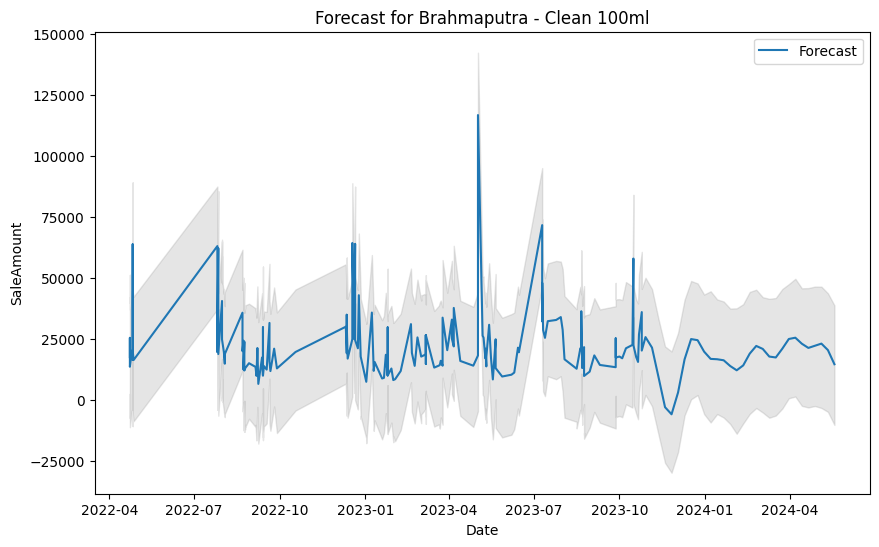

In [43]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(df, location='Brahmaputra', item_name='Clean 100ml', interval='weekly')

In [17]:
pipeline.named_steps['prophet'].transform(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,1.548296e+07,1.553193e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,1.548096e+07,1.553090e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,1.548472e+07,1.553380e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,1.548268e+07,1.553047e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,1.548353e+07,1.553067e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2023-11-20,13722.354027,-2.999673e+04,1.839292e+04,13722.353879,13722.354164,-1.831052e+04,-1.831052e+04,-1.831052e+04,0.000000e+00,...,4166.355702,-22476.876168,-22476.876168,-22476.876168,0.0,0.0,0.0,-4.588166e+03,Brahmaputra,Clean 100ml
762,2023-11-21,13723.861322,-3.358816e+04,1.662575e+04,13723.861162,13723.861474,-2.278043e+04,-2.278043e+04,-2.278043e+04,0.000000e+00,...,630.539009,-23410.969204,-23410.969204,-23410.969204,0.0,0.0,0.0,-9.056569e+03,Brahmaputra,Clean 100ml
763,2023-11-22,13725.368617,-3.426798e+04,1.488831e+04,13725.368445,13725.368778,-2.377313e+04,-2.377313e+04,-2.377313e+04,0.000000e+00,...,327.662121,-24100.793794,-24100.793794,-24100.793794,0.0,0.0,0.0,-1.004776e+04,Brahmaputra,Clean 100ml
764,2023-11-23,13726.875911,-3.863288e+04,9.986777e+03,13726.875723,13726.876086,-2.701495e+04,-2.701495e+04,-2.701495e+04,0.000000e+00,...,-2481.590224,-24533.363857,-24533.363857,-24533.363857,0.0,0.0,0.0,-1.328808e+04,Brahmaputra,Clean 100ml


In [25]:
pipeline.named_steps['prophet'].transform(df, location='Brahmaputra', item_name='Clean 100ml',interval='weekly')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7337.125122,41433.543650,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,-5822.398704,42770.469728,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-7532.776470,41813.394628,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,-4253.325471,42161.185487,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,-7184.237589,42474.994626,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2024-04-21,13952.970111,-2435.189382,45190.767260,13952.966857,13952.973186,7427.433887,7427.433887,7427.433887,0.000,...,4715.368631,2712.065256,2712.065256,2712.065256,0.0,0.0,0.0,21380.403998,Brahmaputra,Clean 100ml
229,2024-04-28,13963.521173,-1696.669702,48691.118815,13963.517665,13963.524385,8282.359008,8282.359008,8282.359008,0.000,...,4715.368631,3566.990377,3566.990377,3566.990377,0.0,0.0,0.0,22245.880181,Brahmaputra,Clean 100ml
230,2024-05-05,13974.072236,-835.203781,48589.580472,13974.068519,13974.075597,9174.570867,9174.570867,9174.570867,0.000,...,4715.368631,4459.202236,4459.202236,4459.202236,0.0,0.0,0.0,23148.643103,Brahmaputra,Clean 100ml
231,2024-05-12,13984.623299,-3111.450701,44704.782224,13984.619381,13984.626843,6518.036391,6518.036391,6518.036391,0.000,...,4715.368631,1802.667760,1802.667760,1802.667760,0.0,0.0,0.0,20502.659690,Brahmaputra,Clean 100ml


In [18]:
# Example of generating and displaying weekly forecast
weekly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='weekly')
weekly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6779.410221,41368.111263,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,10626.215109,57655.958857,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11299.928972,38479.928334,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40237.006779,89582.460395,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36137.444178,84432.416187,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,2024-04-21,15541.120869,-15683.193590,35472.566362,15541.108616,15541.132151,-5749.511190,-5749.511190,-5749.511190,0.000,...,-2038.036593,-3711.474597,-3711.474597,-3711.474597,0.0,0.0,0.0,9791.609679,Turag,Clean 100ml
9659,2024-04-28,15455.303721,-16897.387325,35646.840187,15455.290602,15455.315586,-7048.085296,-7048.085296,-7048.085296,0.000,...,-2038.036593,-5010.048703,-5010.048703,-5010.048703,0.0,0.0,0.0,8407.218425,Turag,Clean 100ml
9660,2024-05-05,15369.486573,-22059.378100,29264.219982,15369.472729,15369.499064,-12438.969160,-12438.969160,-12438.969160,0.000,...,-2038.036593,-10400.932567,-10400.932567,-10400.932567,0.0,0.0,0.0,2930.517413,Turag,Clean 100ml
9661,2024-05-12,15283.669426,-30393.461288,20707.063830,15283.655015,15283.682840,-21206.091228,-21206.091228,-21206.091228,0.000,...,-2038.036593,-19168.054635,-19168.054635,-19168.054635,0.0,0.0,0.0,-5922.421802,Turag,Clean 100ml


In [24]:
# Example of generating and displaying monthly forecast
monthly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='monthly')
monthly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6121.590654,40283.849609,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9159.467333,55104.227039,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-9297.333657,38187.933720,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41005.139325,88088.772389,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,37008.630871,85703.684683,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,2025-11-30,8332.480457,-44760.104915,8412.162145,8332.382040,8332.574704,-28415.089372,-28415.089372,-28415.089372,0.000,...,-2038.036593,-26377.052779,-26377.052779,-26377.052779,0.0,0.0,0.0,-20082.608916,Turag,Clean 100ml
8922,2025-12-31,7952.433088,-14780.188782,36259.462485,7952.329728,7952.532695,2698.103334,2698.103334,2698.103334,0.000,...,-77.029606,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,10650.536422,Turag,Clean 100ml
8923,2026-01-31,7572.385719,-27089.347984,23559.743261,7572.275908,7572.489314,-9054.768713,-9054.768713,-9054.768713,0.000,...,-3434.972866,-5619.795847,-5619.795847,-5619.795847,0.0,0.0,0.0,-1482.382994,Turag,Clean 100ml
8924,2026-02-28,7229.117128,2430.381510,52354.860841,7229.002214,7229.226845,20463.762118,20463.762118,20463.762118,0.000,...,-3434.972866,23898.734984,23898.734984,23898.734984,0.0,0.0,0.0,27692.879247,Turag,Clean 100ml


In [20]:
# Example of generating and displaying half-yearly forecast
half_yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='half-yearly')
half_yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6285.932666,41595.698805,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9897.292570,56825.832084,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11644.044091,36700.254687,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40843.101179,89205.993763,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,38521.527660,83724.204594,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,2036-04-30,-38303.009558,-69656.753721,-19192.640434,-38303.584597,-38302.468514,-6129.389672,-6129.389672,-6129.389672,0.000,...,-77.029606,-6052.360067,-6052.360067,-6052.360067,0.0,0.0,0.0,-44432.399230,Turag,Clean 100ml
8736,2036-10-31,-40558.774585,-6841.953053,44024.050702,-40559.379427,-40558.207071,59823.738609,59823.738609,59823.738609,0.000,...,-2778.751462,62602.490071,62602.490071,62602.490071,0.0,0.0,0.0,19264.964025,Turag,Clean 100ml
8737,2037-04-30,-42777.760834,-82125.175133,-30714.658369,-42778.393429,-42777.167810,-14043.693338,-14043.693338,-14043.693338,0.000,...,-8142.874080,-5900.819258,-5900.819258,-5900.819258,0.0,0.0,0.0,-56821.454172,Turag,Clean 100ml
8738,2037-10-31,-45033.525861,-12406.287351,37702.014908,-45034.197164,-45032.887196,58752.086151,58752.086151,58752.086151,0.000,...,-3434.972865,62187.059017,62187.059017,62187.059017,0.0,0.0,0.0,13718.560290,Turag,Clean 100ml


In [21]:
# Example of generating and displaying yearly forecast
yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='yearly')
yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6140.687578,41953.555795,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8852.177819,55904.293738,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11130.055346,37711.185755,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40207.401443,89044.443285,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36034.737621,84028.803717,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8692,2048-12-31,-95040.403823,-126491.275430,-75996.576827,-95041.588231,-95039.251116,-5397.220583,-5397.220583,-5397.220583,0.000,...,-8142.874080,2745.653497,2745.653497,2745.653497,0.0,0.0,0.0,-100437.624406,Turag,Clean 100ml
8693,2049-12-31,-99515.155099,-127875.027351,-73273.838362,-99516.408155,-99513.951897,-3.618522,-3.618522,-3.618522,0.000,...,-2778.751462,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,-99518.773621,Turag,Clean 100ml
8694,2050-12-31,-103989.906376,-129833.248126,-78441.323119,-103991.221526,-103988.628242,-630.604409,-630.604409,-630.604409,0.000,...,-3434.972865,2804.368457,2804.368457,2804.368457,0.0,0.0,0.0,-104620.510784,Turag,Clean 100ml
8695,2051-12-31,-108464.657652,-133470.064286,-82653.321888,-108466.043419,-108463.324068,795.191488,795.191488,795.191488,0.000,...,-2038.036593,2833.228081,2833.228081,2833.228081,0.0,0.0,0.0,-107669.466164,Turag,Clean 100ml


In [22]:
# Aggregate predictions on a weekly basis
weekly_predictions = forecast.resample('W-Mon', on='ds').sum()
weekly_predictions

NameError: name 'forecast' is not defined

In [ ]:
# Aggregate predictions on a monthly basis
monthly_predictions = forecast.resample('M', on='ds').sum()
monthly_predictions

In [ ]:
# Aggregate predictions on a half_yearly basis
half_yearly_predictions = forecast.resample('6M', on='ds').sum()
half_yearly_predictions

In [ ]:
yearly_predictions = forecast.resample('Y', on='ds').sum()
yearly_predictions